In [1]:
# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import the backend
import tensorflow as tf

# Data preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image


# Model architecture
from tensorflow.keras.models import Sequential
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import  EarlyStopping
from tensorflow.keras.models import Model







# Load Data

In [2]:

train_data = pd.read_csv("/kaggle/input/Kannada-MNIST/train.csv")#train data
test_data = pd.read_csv("/kaggle/input/Kannada-MNIST/test.csv")#test data
val_data = pd.read_csv('/kaggle/input/Kannada-MNIST/Dig-MNIST.csv')#validation data

# Split Data into label and pixels

In [3]:
train = train_data.iloc[:, 1:].values.astype("float32") # cast the values in a NumPy array to floating point numbers with 32 bits of precision.
train_label = train_data.iloc[:, 0].values.astype("int32")#cast the values in a NumPy array to 32-bit signed intergers.
test = test_data.iloc[:, 1:].values.astype("float32")
NumberID = test_data.iloc[:, 0].values.astype("float32")
val = val_data.iloc[:,1:].values.astype('float32') 
val_label = val_data.iloc[:,0].values.astype('int32') 
#I used 32 bit to speed up the calculation 

# Reshape for Image Visualize

In [4]:
Image=train.reshape(-1,28,28)

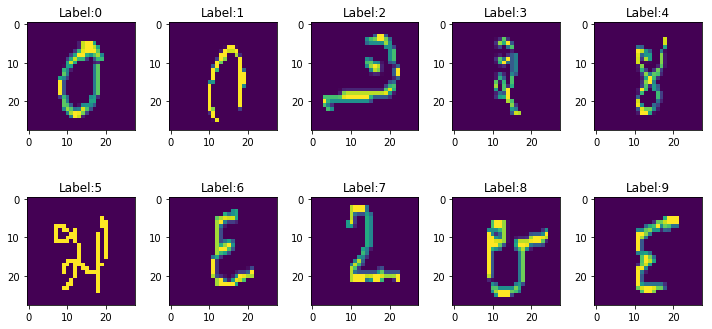

In [5]:
fig, axes = plt.subplots(2,5, figsize = (10,5))
for i in range(10):
    ax = axes[i//5, i%5]
    ax.imshow(Image[i])
    ax.set_title('Label:{}'.format(train_label[i]))

plt.tight_layout()
plt.show()

# Reshape for CNN 
We reshape the value so they can be fed into the CNN network.\
The CNN input has to be (batch_size,image_height, image_width, color_channels).\
We will be using 28 height , 28 width and greyscale image would have a channel of 1.


In [6]:

train=train.reshape(-1,28,28,1) #-1 can be infer as n which means it is the number of row vector, channel of 1 

test=test.reshape(-1,28,28,1)

val = val.reshape(-1,28,28,1)


In [7]:
train.shape, test.shape, val.shape

((60000, 28, 28, 1), (5000, 28, 28, 1), (10240, 28, 28, 1))

# Feature Scaling
We perform feature scaling for machine learning to interprest these features on the same scale. As the pixel values range from 0 to 256, apart from 0 the range is 255. So dividing all the values by 255 will convert it to range from 0 to 1.

In [8]:
# Feature Scaling
train /= 255.0
test /= 255.0
val /=255.0



# Image Data Augmentation
This allows my model to receive new variations of the images at each epoch. My accuracy has improved compare to training without data augmentation.


In [9]:
# Artificially increase training set
train_datagen = ImageDataGenerator(rotation_range=10, #random rotate 10 degree
                                   width_shift_range=0.25,
                                   height_shift_range=0.25,
                                   shear_range=0.1,
                                   zoom_range=0.25, # random zoom
                                   horizontal_flip=False) #do not flip the image horizontal because 6 can be 9 if filpped 
train_datagen.fit(train)

# CNN Model

I used CNN for the image classification because they can effectively extract features from images and learn to recognize patterns. I included BatchNormalization layers to speed up training and use higher learning rates, making learning easier.

In [10]:
# Model architecture (normal)
inputs = Input(shape=(28,28,1))
#1st Layer
#Using paddding = 'SAME' ensures that the filter is applied to all the elements of the input
x = Conv2D(filters = 64, kernel_size = (3,3), padding = "same" ,activation = "relu")(inputs)
x  = BatchNormalization()(x)
x = Conv2D(filters = 64, kernel_size = (1,1),padding = "same" ,activation = "relu")(x)
x  = BatchNormalization()(x)# #used to speed up training and use higher learning rates, making learning easier
x = MaxPooling2D(pool_size=(2,2))(x)

#2nd layer
x = Conv2D(filters = 128, kernel_size = (3,3), padding = "same" ,activation = "relu")(x)
x  = BatchNormalization()(x)
x = Conv2D(filters = 128, kernel_size = (1,1),padding = "same" ,activation = "relu")(x)
x  = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)

#3rd layer
x = Conv2D(filters = 256, kernel_size = (3,3), padding = "same" ,activation = "relu")(x)
x = Conv2D(filters = 256, kernel_size = (1,1),padding = "same" ,activation = "relu")(x)
x  = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)

#4th
x = Conv2D(filters = 512, kernel_size = (3,3),padding = "same" ,activation = "relu")(x)
x  = BatchNormalization()(x)
x = Conv2D(filters = 512, kernel_size = (1,1),padding = "same" ,activation = "relu")(x)
x  = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2,2))(x)



x = Flatten(name='Flatten')(x) 
x = Dense(256, activation='relu', name="Dense_128")(x)
x = Dense(64, activation='relu', name="Dense_64")(x)       
x = Dense(32,activation='relu', name="Dense_16")(x)

output= Dense(10, activation='softmax')(x)

model1=Model(inputs=[inputs], outputs=output)

# Setting Hyperparameters
I choose 50 epochs because it increased 10% of the accuracy for test data /


In [11]:
# Setting hyperparemeters
epochs = 50 
batch_size = 64

Early stopping is used to avoid overfitting. I choose monitor as validation accuracy because I prioritize validation accuracy more. I have selected 10 epochs to wait before early stop. Verbose 1 to display messages when the callback takes an action.

In [12]:
# Early Stopping
early_stopping = EarlyStopping(monitor = 'val_acc',
                               patience = 10,
                               verbose = 1,
                               mode = 'auto',
                               restore_best_weights = True)

# Compile model
Optimizer for adam and sgd doesn't improve the accuracy much for this case but adam increased the speed of training. 

In [13]:
model1.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [14]:
model1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        4160      
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       73856 

In [15]:
history = model1.fit_generator(train_datagen.flow(train,train_label, batch_size = batch_size),
                              epochs = epochs,
                              steps_per_epoch = train.shape[0] // batch_size,
                              validation_data = (val, val_label), 
                              callbacks = [early_stopping])

Train for 937 steps, validate on 10240 samples
Epoch 1/50
937/937 [==============================] - 25s 26ms/step - loss: 0.2468 - accuracy: 0.9173 - val_loss: 0.7895 - val_accuracy: 0.7990
Epoch 2/50
937/937 [==============================] - 20s 22ms/step - loss: 0.0843 - accuracy: 0.9745 - val_loss: 0.6624 - val_accuracy: 0.8434
Epoch 3/50
937/937 [==============================] - 20s 22ms/step - loss: 0.0679 - accuracy: 0.9791 - val_loss: 0.6230 - val_accuracy: 0.8615
Epoch 4/50
937/937 [==============================] - 20s 22ms/step - loss: 0.0636 - accuracy: 0.9809 - val_loss: 0.6783 - val_accuracy: 0.8472
Epoch 5/50
937/937 [==============================] - 20s 22ms/step - loss: 0.0556 - accuracy: 0.9830 - val_loss: 0.6177 - val_accuracy: 0.8365
Epoch 6/50
937/937 [==============================] - 20s 22ms/step - loss: 0.0577 - accuracy: 0.9820 - val_loss: 0.7035 - val_accuracy: 0.8381
Epoch 7/50
937/937 [==============================] - 20s 22ms/step - loss: 0.0517 - accu

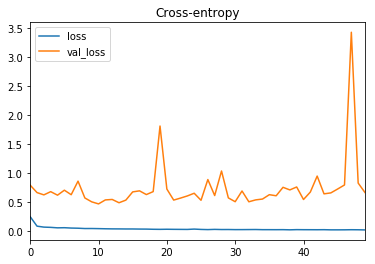

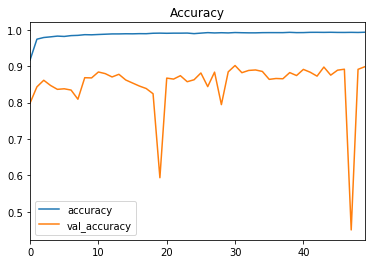

In [16]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title="Accuracy")

In [17]:
# Submitting Predictions to Kaggle
preds = tf.argmax(model1.predict(test),1)

submission = pd.read_csv('/kaggle/input/Kannada-MNIST/sample_submission.csv')
submission['label'] = preds
submission.to_csv('submission.csv', index = False)